In [1]:
import datajoint as dj
import pandas as pd
import numpy as np
import time

import matplotlib.pyplot as plt
import ipyvolume.pylab as p3

In [ ]:
ta3p100 = dj.create_virtual_module('ta3p100', 'microns_ta3p100')

Connecting cpapadop@10.28.0.34:3306


In [ ]:
fetched_mesh = (ta3p100.Mesh & ta3p100.CurrentSegmentation & 'segment_id=648518346341351503').fetch1()

In [ ]:
fetched_mesh = ta3p100.Decimation35.fetch(limit=1, as_dict=True)[0]

In [ ]:
fetched_mesh = (ta3p100.Mesh & ta3p100.CurrentSegmentation & 'segment_id=648518346341366885').fetch1()

In [ ]:
class Voxel:
    def __init__(self, vertices):
        self._vertices = vertices.copy()
        
    @property
    def vertices(self):
        return self._vertices
        
    @staticmethod
    def get_bbox(vertices):
        return np.array([(np.min(axis), np.max(axis)) for axis in vertices.T])
        
    @property
    def bbox(self):
        return self.get_bbox(self.vertices)
    
    @property
    def _rectangular_idx(self):
        X = [0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0]
        Y = [0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0]
        Z = [0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0]
        return np.vstack((X, Y, Z))
    
    @property
    def voxels(self):
        return self._voxels
    
    @voxels.setter
    def voxels(self, voxels):
        self._voxels
    
    @property
    def offset(self):
        return self._offset
    
    @offset.setter
    def offset(self, side_length):
        self._offset = side_length
    
    @property
    def structure(self):
        return self._structure
        
    @structure.setter
    def structure(self, structure):
        self._structure = structure # I just store each voxel as an offset value vector.
    
    @property
    def voxel_vertices(self):
        return self._voxel_vertices
    
    @voxel_vertices.setter
    def voxel_vertices(self, voxel_vertices):
        self._voxel_vertices = voxel_vertices
    
    @property
    def structure_to_bboxes(self):
        voxel_min = self.bbox[:,0] + (self.structure * self.offset)
        voxel_max = voxel_min + self.offset
        return np.stack([voxel_min, voxel_max], axis=2)
    
    @property
    def voxel_bboxes_to_drawable(self):
        return self.structure_to_bboxes[:, np.arange(3), self._rectangular_idx.T].transpose(0, 2, 1)
    
    @property
    def volume(self):
        """
        Returns the estimation of volume based on the voxelization. Units are the same as the vertex input.
        """
        return self.offset**3 * len(self.structure)
    
    # Could have a more configurable plotting function. Like you give the argument ['mesh', 'structure', 'mesh_bbox', etc.]
    def plot_structure(self, voxel_count_offset=0, voxel_limit=None, use_centroids_instead=False, width=800, height=600):
        p3.figure(width=width, height=height)
        p3.plot_trisurf(*fetched_mesh['vertices'].T/1000, triangles=fetched_mesh['triangles'])#[:10000])
        if use_centroids_instead:
            centroids = mesh.structure_to_bboxes.mean(axis=2)
            if voxel_limit is not None:
                centroids = centroids[:1000]
            p3.scatter(*centroids.T/1000, color='blue', marker='sphere', size=0.25)
        else:
            # Make it so voxel_limit can be larger 
            bboxes = self.voxel_bboxes_to_drawable
            voxel_count = len(bboxes)
            if voxel_count_offset >= voxel_count:
                voxel_count_offset = voxel_count - 1
            if voxel_limit is not None:
                if voxel_limit < (voxel_count + voxel_count_offset):
                    bboxes = bboxes[voxel_count_offset:voxel_count_offset+voxel_limit]
                else:
                    bboxes = bboxes[voxel_count_offset:]
            for bbox in self.voxel_bboxes_to_drawable:
                p3.plot(*bbox/1000, color='blue')
        # Can make xyzlim stuck to the bboxes that are actually plotted.
        p3.squarelim()
        p3.show()
    
#     @structure.indexer
#     def structure(self, index_tuple):
#         return self.structure[index_tuple] # self._structure[index_tuple]

#     def plot_voxels(self):
#         # Scale and transpose
#         center = [4, 4, 4];
#         cubesize = 2;
#         # Vertices for Line Cube. Order matters
#         X = [0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0]
#         Y = [0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0]
#         Z = [0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0]
#         # Example two cube matrix. Unit cube and one scaled/translated cube
#         X1 = [X X*cubesize+center(1)];
#         Y1 = [Y Y*cubesize+center(2)];
#         Z1 = [Z Z*cubesize+center(3)];
#         # Single plot command for all 'cube lines'
#         plot3(X1,Y1,Z1);
    
    def plot_mesh(self, width=800, height=600):
        p3.figure(width=width, height=height)
        p3.plot_trisurf(*fetched_mesh['vertices'].T/1000, triangles=fetched_mesh['triangles'])
        p3.plot(*np.array([axis[idx] for axis, idx in zip(self.bbox, self._rectangular_idx)])/1000, color='blue')
        p3.squarelim()
        p3.show()
    
    def plot_voxels(self, width=800, height=600):
        rectangular_idx = self._rectangular_idx
        p3.figure(width=width, height=height)
        p3.plot_trisurf(*fetched_mesh['vertices'].T/1000, triangles=fetched_mesh['triangles'])
        [p3.plot(*np.array([axis[idx] for axis, idx in zip(bbox, rectangular_idx)])/1000, color='blue') for bbox in self.voxels]
        p3.squarelim()
        p3.show()
    
    @staticmethod
    def _sort_vertex_rows(vertices):
        # This still might be slower.
        a = vertices
        a = a[a[:,2].argsort()] # First sort doesn't need to be stable.
        a = a[a[:,1].argsort(kind='mergesort')]
        a = a[a[:,0].argsort(kind='mergesort')]
        return a
    
    def cube_voxelize(self, side_length):
        self.offset = side_length
        bbox = self.bbox
        # Get the number of voxels to be used to create cubes (allowing for pushing past the boundaries).
        num_voxels = np.ceil((np.abs(np.subtract(*bbox.T) / side_length))).astype(int)
        
        # Create the cube voxel grid split structure. Could also sort the vertices according to the grid at this point?
        start_coord = bbox.T[0]
        cube_friendly_bbox = np.vstack((start_coord, start_coord + (num_voxels * side_length))).T
        x_edges, y_edges, z_edges = [np.arange(minimum, maximum, side_length) for minimum, maximum in cube_friendly_bbox]
#         print([len(x_edges), len(y_edges), len(z_edges)])        
        
        # With this version, I am again missing a portion of it.
        offset_vectors = list()
        voxel_vertices = dict()
        
        sorted_idx = mesh.vertices.T[0].argsort()
        x_verts = mesh.vertices[sorted_idx]
        splitter = x_verts.T[0].searchsorted(x_edges)
        x_split = np.split(x_verts, splitter)
        for i, x_block in enumerate(x_split):
            if len(x_block) > 0:
                sorted_idx = x_block.T[1].argsort()
                y_verts = x_block[sorted_idx]
                splitter = y_verts.T[1].searchsorted(y_edges)
                y_split = np.split(y_verts, splitter)
                if len(y_split) > 0:
                    for j, y_block in enumerate(y_split):
                        if len(y_block) > 0:
                            sorted_idx = y_block.T[2].argsort()
                            z_verts = y_block[sorted_idx]
                            splitter = z_verts.T[2].searchsorted(z_edges)
                            z_split = np.split(z_verts, splitter)
                            if len(z_split) > 0:
                                for k, z_block in enumerate(z_split):
                                    if len(z_block) > 0:
                                        vector = (i, j, k)
                                        offset_vectors.append(vector)
                                        voxel_vertices[tuple(np.array(vector)-1)] = z_block
                                        
        self.structure = np.array(offset_vectors) - 1
        self.voxel_vertices = voxel_vertices
        
        return self.structure
    
        sorted_verts = self._sort_vertex_rows(mesh.vertices)

        splitter = sorted_verts[:,0].searchsorted(x_edges)
        x_split = np.split(sorted_verts, splitter)
        
        splitter = sorted_verts[:,1].searchsorted(y_edges)
        y_split = np.split(sorted_verts, splitter)
        
        splitter = sorted_verts[:,2].searchsorted(z_edges)
        z_split = np.split(sorted_verts, splitter)
        
        offset_vectors = list()
        
        # Potentially can now do a combinatorial thing between all of them. Maybe for each pair do a set intersection?
        # Well, I literally only care to see if there are any vertices at all at the intersection, then I'll return an offset vector for each voxel.
        for i, x_block in enumerate(x_split):
            # This way of doing combinatorial is very inefficient, should use a numpy.apply_across_axis or something once I verify it works first.
            # Or I just go the way of doing the searchsorted with this loop and just keep track of the voxel indices using the same i, j, k
            # btw pretty sure that i, j, k can be directly used as the offset vector indices.
            for j, y_block in enumerate(y_split):
                for k, z_block in enumerate(z_split):
                    if len(set.intersection(x_block, y_block, z_block)): offset_vectors.append((i, j, k))
        
        offset_vectors = np.array(offset_vectors)
        return offset_vectors
        
        # Tag the voxels that have vertices. Keep track of the structure offset indices. But should I also keep track of voxel ids? Probably not if
        # I do it where each voxel just holds the offset.
        
        
        # Could I tag vertices for each voxel? How expensive would that be, but it would be very easy and efficient querying and manipulating afterwords.
        
        # Query number of vertices in large chunks and then split down into the medium then 1-1 voxel resolution.
        
        # To get the indices of the vertex blocks with vertices, do ( BUT this doesn't actually work, but you get the idea )
        # summed = vertex_blocks.sum(axis=whatever_works)
        # idx = np.where(summed>0)
        
        # Will also need to have a voxel-level "bbox" where it re-corners (moves it to the topmost-leftmost corner, or some other corner) the starting
        # voxel structure centroid (or corner coordinate, this decision affects from where the offset is calculated) to the location that agrees with the
        # existing offset distance settings and then it should be able to easily add/subtract the offset change from the offset indices stored in the voxel
        # offset vectors.

In [5]:
# Try voxelizing a mesh with all of the spines removed using the labeled spines.

In [6]:
mesh = Voxel(fetched_mesh['vertices'])

In [28]:
%%time

start = time.time()
thing = mesh.cube_voxelize(1000) #2048 #2500
print(time.time() - start), print(len(thing)), print(mesh.volume)

0.6638071537017822
12352
12352000000000
CPU times: user 666 ms, sys: 0 ns, total: 666 ms
Wall time: 664 ms


In [8]:
blocks = np.array([vertices for vertices in mesh.voxel_vertices.values()])
block_lens = np.array([len(vertices) for vertices in blocks])
block_lens

array([355,   1, 119, ...,  20,   2,  87])

(array([1.161e+03, 5.480e+02, 3.840e+02, 2.680e+02, 1.820e+02, 1.610e+02,
        1.330e+02, 1.190e+02, 8.900e+01, 9.800e+01, 8.500e+01, 4.500e+01,
        5.000e+01, 3.300e+01, 2.600e+01, 1.500e+01, 1.100e+01, 6.000e+00,
        2.000e+00, 0.000e+00, 1.000e+00, 1.000e+00, 0.000e+00, 0.000e+00,
        1.000e+00]),
 array([1.0000e+00, 8.3200e+01, 1.6540e+02, 2.4760e+02, 3.2980e+02,
        4.1200e+02, 4.9420e+02, 5.7640e+02, 6.5860e+02, 7.4080e+02,
        8.2300e+02, 9.0520e+02, 9.8740e+02, 1.0696e+03, 1.1518e+03,
        1.2340e+03, 1.3162e+03, 1.3984e+03, 1.4806e+03, 1.5628e+03,
        1.6450e+03, 1.7272e+03, 1.8094e+03, 1.8916e+03, 1.9738e+03,
        2.0560e+03]),
 <a list of 25 Patch objects>)

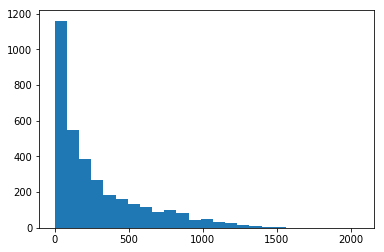

In [9]:
plt.hist(block_lens, bins=25)

In [10]:
len(block_lens[block_lens<100]), len(block_lens)

(1271, 3419)

In [11]:
mesh.structure = mesh.structure[(block_lens>=100)]
len(mesh.structure)

2148

In [12]:
mesh.plot_structure(use_centroids_instead=False)

In [79]:
# Start looking about how to standardize access to the structure.
# I want a very consistent and stable structure.

st = mesh.structure.copy()

st

array([[  0,  37,  20],
       [  0,  37,  21],
       [  0,  38,  20],
       ...,
       [107,  79,  35],
       [107,  80,  34],
       [107,  80,  35]])

In [ ]:
# From there I need to start being able to compute several sets of statistics on the voxelization.

In [23]:
class Voxels:
    def __init__(self, origin, side_length, offset_vectors=None):
        """
        :param origin: The starting location of which the voxels will be offset from.
        :param side_length: The length of a side of a voxel (they are cubes).
        :param offset_vectors: The structure that stores the locations of the voxels as offset integers from the origin (using the side length as the increment).
        """
        self.origin = origin
        self.side_length = side_length
        if offset_vectors is not None:
            self.offset_vectors = offset_vectors
        
    @property
    def origin(self):
        return np.array((self._x, self._y, self._z))
    
    @origin.setter
    def origin(self, coordinate):
        self._x, self._y, self._z = coordinate
        
    @property
    def side_length(self):
        return self._side_length
    
    @side_length.setter
    def side_length(self, side_length):
        self._side_length = side_length
        
    @property
    def offset_vectors(self):
        return self._offset_vectors
    
    @offset_vectors.setter
    def offset_vectors(self, offset_vectors):
        if offset_vectors.shape == (len(offset_vectors), 3):
            self._offset_vectors = offset_vectors
        else:
            raise TypeError("Array shape is incorrect, should be equivalent to (-1, 3).")
            
            
    # Maybe I should make this search_by_offset pretty extensible by some design? Like allow you to easily search by a bunch of x offsets,
    # or even all of them. And also still be able to search for a certain offset like (0, 37, 20). Basically be able to search for a row,
    # or from a column or a bunch of columns or for a bunch of rows, etc.
    
#     def search_by_offset(self, x_offset, y_offset, z_offset):
#         return np.where((vs.offset_vectors==(x_offset, y_offset, z_offset)).all(axis=1))[0]
    def search_by_offset(self, key):
        print(type(self.offset_vectors==key))
        return np.where((self.offset_vectors==key).all(axis=1))[0]

In [24]:
vs = Voxels(np.zeros(3, int), 10) # Should allow to use the precision of integers across the whole thing.

In [25]:
vs.offset_vectors = thing.copy()

In [26]:
key = (0, 37, 20)
vs.search_by_offset(key)

<class 'numpy.ndarray'>


array([0])

In [18]:
keys = 
vs.search_by_offset()

SyntaxError: invalid syntax (<ipython-input-18-3a35bafbaa99>, line 1)

In [204]:
np.where((vs.offset_vectors==key).all(axis=1))[0]

array([0])

In [202]:
from collections import Iterable
l = [1, 2, 3, 4]
print(isinstance(l, Iterable))

# This can be finished after the vector storing stuff is done.
def search(x_offset=None, y_offset=None, z_offset=None):
    """
    The purpose of this function is to standardize access to the voxel structure and be able to access voxels even if the number of entries in the structure changes.
    """
    # Essentially they should be able to enter in any combination of x_offset, y_offset, and z_offset to return the index from a structure that can then be used
    # to access a voxel or many voxels.
    # If they give an x_offset and a z_offset then it should find all voxels with that have both that x_offset and z_offset (so the only thing that'll differ
    # is the y_offset).
    # Is it worth it to allow them to input say, several x_offsets and then have it be combinatorial if the number of y_offsets differ?
    # Perhaps make it be an option that they have to explicitly choose. So either it'll expect at most a list of offset vectors, and if the lengths differ
    # (besides the case where an offset is still set as None) then it'll raise an exception and ask if they wanted the combinatorial (factorization) option.
    
    try:
        key = dict()
        key['x'] = x_offset, y=y_offset, z=z_offset
        
        single_voxel_flag = True
        # Do it the simple way first.
        if x_offset is None:
            single_voxel_flag = False
        if y_offset is None:
            single_voxel_flag = False
        if z_offset is None:
            single_voxel_flag = False
        
        if single_voxel_flag:
            idx = np.where((vs.offset_vector==key).all(axis=1))[0]
        
        if key is not np.ndarray:
            key = np.array(key)
        
        shape = key.shape
        
        if len(shape) > 0:
#             if shape[0] > 3:
            idx = np.where((vs.offset_vector==key).all(axis=1))[0]
        
        if shape == (len(key),)
            idx = np.where((vs.offset_vectors==key).all(axis=1))[0]
        elif key.shape
            
        return idx
    except Exception as e:
        Print(e)

In [203]:
key1 = (0, 37, 20)
key2 = (1)
key3 = (3, 4, np.nan)
search(key1), search(key2), search(key3)

(array([0]), array([], dtype=int64), array([], dtype=int64))

In [213]:
len(np.array(key2).shape)

0

In [211]:
np.array(key1).shape == (len(key1),)

True

In [215]:
shape, key_length = np.array(key1).shape, len(key1)

In [217]:
print(shape)
print(key_length)

(3,)
3


In [157]:
import networkx as nx

In [158]:
# Figure out how to use networkx for the mesh segmentation I want.
# Maybe would be possible to do what I need to directly on the vertex neighborhood (requires vertices and triangles to generate)

In [159]:
G = nx.Graph()

In [168]:
G.add_node((tuple(eh) for eh in thing))

In [173]:
G.add_node(0)

In [176]:
G.adj

AdjacencyView({<generator object <genexpr> at 0x7fa9183ac9e8>: {}, 0: {}})

In [ ]:
# @schema if schema = dj.schema('microns_ta3p100')
class VoxelConfig(dj.Lookup):
    definition = """
    side_length   : decimal(10, 5)
    ---
    # side_length : float # hmm, I wanted the side length to be something I can use. Maybe I should force them to be integers or decimal? Yeah decimal
                        # would actually pretty helpful.
    """
    
class Voxels(dj.Computed):
    definition = """
    -> ta3p100.Mesh
    -> VoxelConfig
    """
    
    key_source = ta3p100.Mesh * VoxelConfig
    
    class Structure(dj.Part):

In [ ]:
# outdated

sorted_idx = nonisolated_vertices.T[0].argsort()
x_verts = nonisolated_vertices[sorted_idx]
splitter = x_verts.T[0].searchsorted(x_edges)
x_split = np.split(x_verts, splitter)
for x_block in x_split:
    if len(x_block) > 0:
        sorted_idx = x_block.T[1].argsort()
        y_verts = x_block[sorted_idx]
        splitter = y_verts.T[1].searchsorted(y_edges)
        y_split = np.split(y_verts, splitter)
        if len(y_split) > 0:
            for y_block in y_split:
                if len(y_block) > 0:
                    sorted_idx = y_block.T[2].argsort()
                    z_verts = y_block[sorted_idx]
                    splitter = z_verts.T[2].searchsorted(z_edges)
                    z_split = np.split(z_verts, splitter)
                    if len(z_split) > 0:
                        for z_block in z_split:
                            if len(z_block) > 0:
                                bboxes.append(self.get_bbox(z_block))